# Gold Price Prediction
## Implementation with Tensorflow on AWS

In [2]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

ValueError: Must setup local AWS configuration with a region supported by SageMaker.

In [1]:
import codecs, json
import time

# Web-scrapping Yahoo Finance data
import yfinance as yf

# Data ETL
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')

# Training & Testing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## Collect Data

We scrap the value for gold from Yahoo Finace:

In [85]:
stocks = [
    {"stock_name": "Standard and Poor's (S&P) 500 index", "stock_ticker": "^GSPC", "feature": True},
    {"stock_name": "Dow Jones Industrial Average", "stock_ticker": "^DJI", "feature": True},
    {"stock_name": "Crude Oil", "stock_ticker": "CL=F", "feature": True},
    {"stock_name": "Gold Miners ETF", "stock_ticker": "GLD", "target": "GLD Adj Close", "feature": False}
]

# Save example for server
file_path = "stocks.json"
json.dump(stocks, codecs.open(file_path, 'w', encoding='utf-8'), 
          separators=(',', ':'), 
          sort_keys=True, 
          indent=4)

# Lets have a look at the Gold Miners ETF information
gld = yf.Ticker(stocks[-1]["stock_ticker"])
# gld.info

In [96]:
# Now lets collect the data from the companies
data = yf.download(
    " ".join([obs['stock_ticker'] for obs in stocks]), 
    start="2000-01-01",
    end="2022-06-01",
    group_by='ticker')

data.columns = data.columns.map('_'.join)
data.columns = [c.lower() for c in data.columns]
data.columns = [c.replace("^", "") for c in data.columns]
data.columns = [c.replace("=", "") for c in data.columns]
data.columns = [c.replace(" ", "_") for c in data.columns]
data.reset_index()
print("Total number of observations is:", len(data))
data

[*********************100%***********************]  4 of 4 completed
Total number of observations is: 5644


,gld_open,gld_high,gld_low,gld_close,gld_adj_close,gld_volume,clf_open,clf_high,clf_low,clf_close,...,gspc_low,gspc_close,gspc_adj_close,gspc_volume,dji_open,dji_high,dji_low,dji_close,dji_adj_close,dji_volume
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1458.189941,1469.250000,1469.250000,3.740500e+08,11453.480469,11542.410156,11442.820312,11497.120117,11497.120117,43620000.0
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1438.359985,1455.219971,1455.219971,9.318000e+08,11501.849609,11522.009766,11305.690430,11357.509766,11357.509766,169750000.0
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1397.430054,1399.420044,1399.420044,1.009000e+09,11349.750000,11350.059570,10986.450195,10997.929688,10997.929688,178420000.0
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1377.680054,1402.109985,1402.109985,1.085500e+09,10989.370117,11215.099609,10938.669922,11122.650391,11122.650391,203190000.0
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1392.099976,1403.449951,1403.449951,1.092300e+09,11113.370117,11313.450195,11098.450195,11253.259766,11253.259766,176550000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,173.470001,174.410004,173.350006,174.130005,174.130005,6794000.0,110.410004,111.430000,108.610001,109.769997,...,3875.129883,3941.479980,3941.479980,3.901640e+09,31717.609375,32014.859375,31365.589844,31928.619141,31928.619141,382950000.0
2022-05-25,172.789993,173.160004,171.729996,173.080002,173.080002,4595900.0,110.389999,111.680000,109.230003,110.330002,...,3925.030029,3978.729980,3978.729980,4.322190e+09,31816.310547,32254.439453,31754.330078,32120.279297,32120.279297,343460000.0
2022-05-26,172.130005,172.929993,171.759995,172.759995,172.759995,6467000.0,110.690002,114.830002,110.269997,114.089996,...,3984.600098,4057.840088,4057.840088,3.961940e+09,32248.169922,32774.140625,32248.169922,32637.189453,32637.189453,351220000.0


## ETL Data

In [97]:
def log_return(series, periods = 1) :
    return np.log(series).diff(periods = periods)

In [98]:
stock_tickers = [obs['stock_ticker'] for obs in stocks if obs['feature']]
stock_tickers = [st.lower() for st in stock_tickers]
stock_tickers = [st.replace("^", "") for st in stock_tickers]
stock_tickers = [st.replace("=", "") for st in stock_tickers]
stock_tickers = [st.replace(" ", "_") for st in stock_tickers]
stock_tickers

['gspc', 'dji', 'clf']

In [99]:
stock_ticker_target = [obs['target'] for obs in stocks if not obs['feature']]
stock_ticker_target = [st.lower() for st in stock_ticker_target]
stock_ticker_target = [st.replace("^", "") for st in stock_ticker_target]
stock_ticker_target = [st.replace("=", "") for st in stock_ticker_target]
stock_ticker_target = [st.replace(" ", "_") for st in stock_ticker_target]
stock_ticker_target[0]

'gld_adj_close'

/home/dsaenz/conda_envs/gold_prediction/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dsaenz/conda_envs/gold_prediction/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


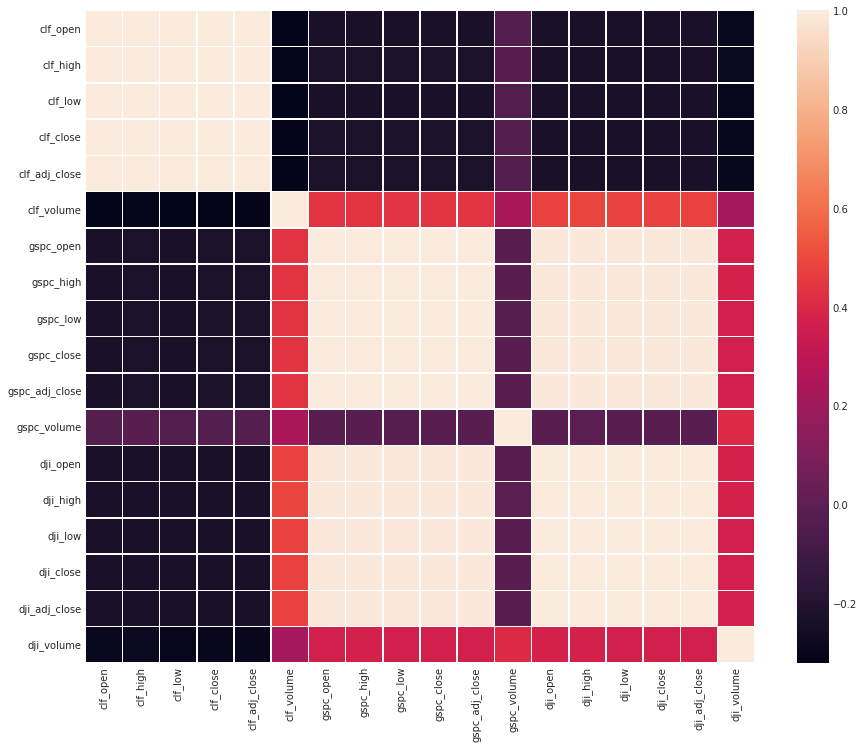

In [160]:
X_features = [col for col in data.columns for st in stock_tickers if re.search(f'^{st}', col)]
df = data[X_features]
# df['target'] = log_return(data['gld_close']).shift(-1)
df['target'] = data[stock_ticker_target[0]].shift(-1)
df.dropna(inplace=True)

# Check what features are highly correlated between them
cor_map = df.iloc[:, :-1].corr()
ax = sns.heatmap(cor_map, xticklabels=True, yticklabels=True, linewidths=.5)

In [161]:
feature_corr_map = df.iloc[:, :-1].corr()
feature_corr_map = feature_corr_map - np.eye(feature_corr_map.shape[0])
to_drop = [column for column in feature_corr_map.columns if any(abs(feature_corr_map[column]) > 0.5)]

to_drop_chosen = []
for st in stock_tickers:
    temp = [c for c in to_drop if re.search(f'^{st}', c)]
    to_drop_chosen.extend(temp[:-1])
df = df.drop(columns=to_drop_chosen, axis=1)
df

,clf_adj_close,clf_volume,gspc_adj_close,gspc_volume,dji_adj_close,dji_volume,target
Date,,,,,,,
2004-11-17,46.840000,83143.0,1181.939941,1.684200e+09,10549.570312,295230000.0,44.380001
2004-11-18,46.220001,71121.0,1183.550049,1.456700e+09,10572.549805,242230000.0,44.779999
2004-11-19,48.439999,140160.0,1170.339966,1.526600e+09,10456.910156,275340000.0,44.950001
2004-11-22,48.639999,85969.0,1177.239990,1.392700e+09,10489.419922,240410000.0,44.750000
2004-11-23,48.939999,96048.0,1176.939941,1.428300e+09,10492.599609,254780000.0,45.049999
...,...,...,...,...,...,...,...
2022-05-23,110.290001,215623.0,3973.750000,3.392770e+09,31880.240234,402010000.0,174.130005
2022-05-24,109.769997,224794.0,3941.479980,3.901640e+09,31928.619141,382950000.0,173.080002
2022-05-25,110.330002,191370.0,3978.729980,4.322190e+09,32120.279297,343460000.0,172.759995


In [102]:
df_train, df_val = train_test_split(df, test_size=0.15, shuffle = False)

# Normalize data using training information
scaler = MinMaxScaler()
scaler.fit(df_train)
X_train = scaler.transform(df_train)
X_val = scaler.transform(df_val)

X_val, X_test = train_test_split(X_val, test_size=0.33, shuffle = False)

In [103]:
df_val, df_test = train_test_split(df_val, test_size=0.33, shuffle = False)

## Training

In [104]:
def conv_sequence_input(data, target_column=-1, window_size=64):
    X = []
    y = []

    for i in range(0 , data.shape[0] - window_size, 1):
        temp2 = []
        for t in range(window_size):
            temp2.append(data[i + t, 0])
        X.append(np.array(temp2).reshape(window_size, 1))
        y.append(data[i + window_size, target_column])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    if X.shape[1] > 1:
        for j in range(1, data.shape[1]):
            temp = []
            for i in range(0 , data.shape[0] - window_size, 1):
                temp2 = []
                for t in range(window_size):
                    temp2.append(data[i + t, j])
                temp.append(np.array(temp2).reshape(window_size, 1))
            X = np.concatenate((X, temp), axis=-1)

    return X, y

In [105]:
window_size = 64

X_train, y_train = conv_sequence_input(X_train, target_column=-1, window_size=window_size)
X_val, y_val = conv_sequence_input(X_val, target_column=-1, window_size=window_size)
X_test, y_test = conv_sequence_input(X_test, target_column=-1, window_size=window_size)

In [106]:
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print("Training data shape:", X_train.shape)
print("Training data shape:", X_val.shape)
print("Training data shape:", X_test.shape)

Training data shape: (3678, 1, 64, 7)
Training data shape: (378, 1, 64, 7)
Training data shape: (155, 1, 64, 7)


In [107]:
def build_model(optimizer='adam', activation='relu', conv_filters=64, kernel_size=3, window_size=64, n_time_features=4, seq_neurons=120, dropout_rate=0.5, dense_neurons=16) :
    inputs = keras.layers.Input(shape = (None, window_size, n_time_features,))
    x = keras.layers.TimeDistributed(keras.layers.Conv1D(conv_filters, kernel_size=kernel_size, activation=activation))(inputs)
    x = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2))(x)
    x = keras.layers.TimeDistributed(keras.layers.Conv1D(conv_filters * 2, kernel_size=kernel_size, activation=activation))(x)
    x = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2))(x)
    x = keras.layers.TimeDistributed(keras.layers.Conv1D(conv_filters * 3, kernel_size=kernel_size, activation=activation))(x)
    x = keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2))(x)
    x = keras.layers.TimeDistributed(keras.layers.Flatten())(x)

    x = keras.layers.Bidirectional(keras.layers.LSTM(seq_neurons, return_sequences=True))(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(seq_neurons, return_sequences=False))(x)
    x = keras.layers.Dropout(dropout_rate)(x)

    x = keras.layers.Dense(dense_neurons)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    
    model = keras.models.Model(inputs = inputs,
                               outputs = outputs)

    model.compile(
        optimizer = optimizer,
        loss = keras.losses.MeanAbsoluteError(),
        metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse'), keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

In [108]:
model = build_model(seq_neurons = 2 * window_size, dense_neurons = 512, window_size = window_size, n_time_features=X_train.shape[-1])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 64, 7)]     0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, None, 62, 64)      1408      
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 31, 64)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 29, 128)     24704     
_________________________________________________________________
time_distributed_31 (TimeDis (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, None, 12, 192)     73920     
_________________________________________________________________
time_distributed_33 (TimeDis (None, None, 6, 192)      0   

In [109]:
cb = [
    keras.callbacks.EarlyStopping(patience = 10,
                                  mode = 'min',
                                  monitor = 'val_rmse',
                                  restore_best_weights = True),
    keras.callbacks.ModelCheckpoint(filepath="/l/users/dsaenz/GoldPricePrediction/Models/weights.hdf5",
                                    monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=True,
                                    mode='min',),
    keras.callbacks.TensorBoard(log_dir="/l/users/dsaenz/GoldPricePrediction/logs",
                                histogram_freq=1),
    keras.callbacks.ReduceLROnPlateau(patience = 5,
                                      mode = 'min',
                                      monitor = 'val_rmse',
                                      factor = .3,
                                      min_lr = 1e-5)
]

model = KerasRegressor(
    build_model, epochs = 100, callbacks = cb, batch_size = 128, verbose = 1, seq_neurons = 2 * window_size,
    optimizer = 'adam', dense_neurons = 512, window_size = window_size, n_time_features=X_train.shape[-1]
)

In [110]:
history = model.fit(X_train, y_train,
          validation_data = (X_val, y_val))

Epoch 1/100
29/29 [==============================] - 7s 84ms/step - loss: 0.2826 - rmse: 0.3651 - mae: 0.2826 - val_loss: 0.6226 - val_rmse: 0.6270 - val_mae: 0.6226

Epoch 00001: val_loss improved from inf to 0.62265, saving model to /l/users/dsaenz/GoldPricePrediction/Models/weights.hdf5
Epoch 2/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0653 - rmse: 0.0839 - mae: 0.0653 - val_loss: 0.5560 - val_rmse: 0.5608 - val_mae: 0.5560

Epoch 00002: val_loss improved from 0.62265 to 0.55598, saving model to /l/users/dsaenz/GoldPricePrediction/Models/weights.hdf5
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0557 - rmse: 0.0705 - mae: 0.0557 - val_loss: 0.5049 - val_rmse: 0.5102 - val_mae: 0.5049

Epoch 00003: val_loss improved from 0.55598 to 0.50491, saving model to /l/users/dsaenz/GoldPricePrediction/Models/weights.hdf5
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0491 - rmse: 0.0631 - mae: 0.0491 - val_los

In [14]:
%tensorboard --logdir /l/users/dsaenz/GoldPricePrediction/logs

UsageError: Line magic function `%tensorboard` not found.


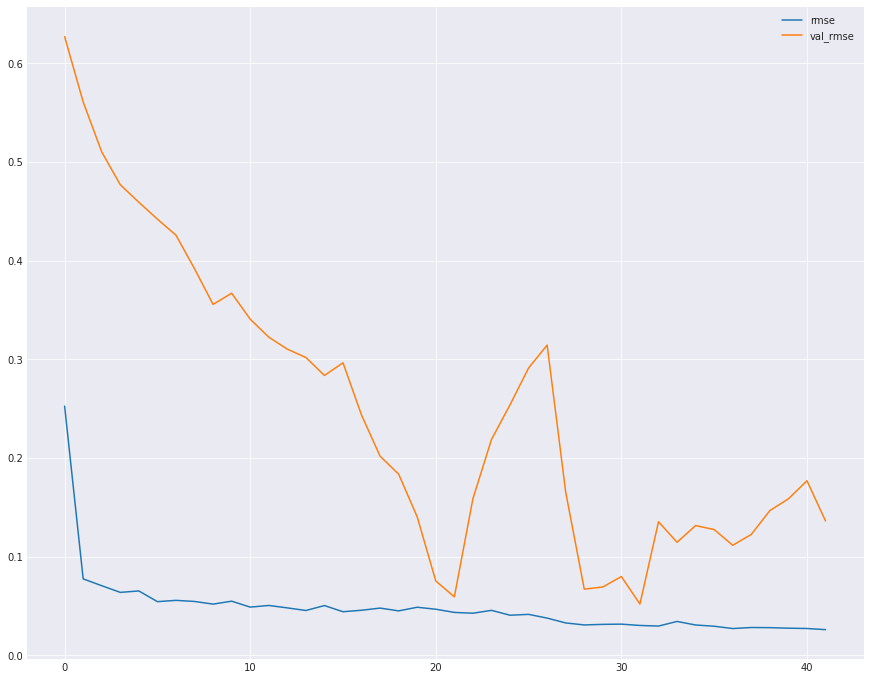

In [111]:
history = pd.DataFrame(history.history)
_ = history.loc[:, ['rmse', 'val_rmse']].plot.line()

2/2 [==============================] - 1s 7ms/step
RMSE : 0.049946743579196325
Correlation : 0.030194278906643605


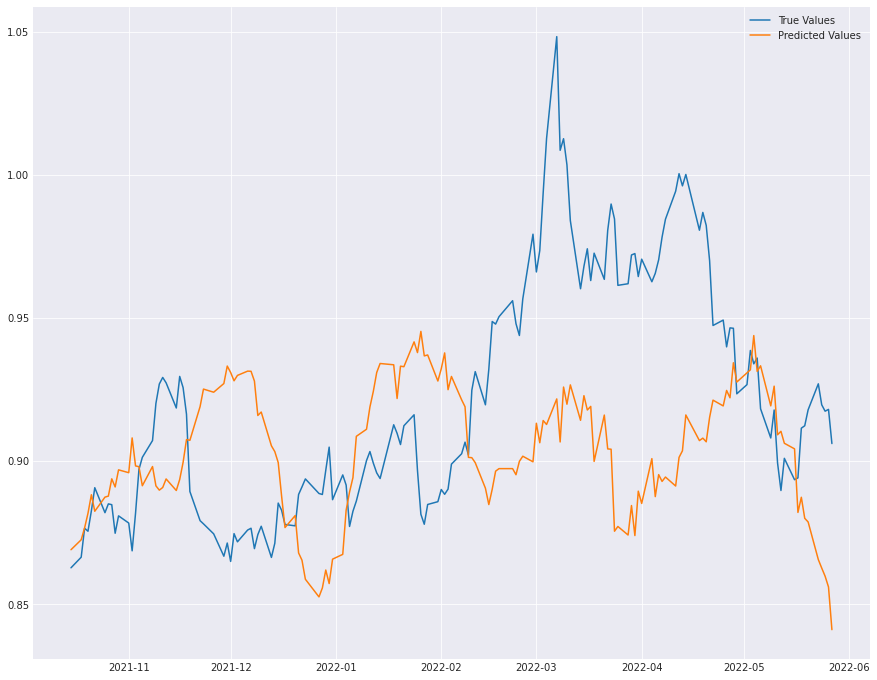

In [112]:
y_hat = np.array(
    model.predict(X_test)
).reshape(-1, 1)
print('RMSE :', np.sqrt(np.mean(np.square(y_test - y_hat))))
print('Correlation :', np.corrcoef(y_test.squeeze(1), y_hat.squeeze(1))[1, 0])
plt.plot(df_test.index[window_size:], y_test, label = 'True Values')
plt.plot(df_test.index[window_size:], y_hat, label = 'Predicted Values')
plt.legend()
plt.show()

#### Create example for server

In [68]:
import codecs, json

server_example = np.expand_dims(X_test[0], axis=0)
server_example = server_example.tolist()

# Save example for server
file_path = "events/event.json"
json.dump(server_example, codecs.open(file_path, 'w', encoding='utf-8'), 
          separators=(',', ':'), 
          sort_keys=True, 
          indent=4) 

### Save model

In [61]:
ts = int(time.time())
file_path = "/l/users/dsaenz/GoldPricePrediction/Models" + f"/gold_price_predictor/{ts}/"
model.model.save(filepath=file_path, save_format='tf')

INFO:tensorflow:Assets written to: /l/users/dsaenz/GoldPricePrediction/Models/gold_price_predictor/1654753592/assets


INFO:tensorflow:Assets written to: /l/users/dsaenz/GoldPricePrediction/Models/gold_price_predictor/1654753592/assets
